In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# plt.style.use(['seaborn-pastel','dark_background'])
mpl.rcParams['figure.facecolor'] = 'whitesmoke'
mpl.rcParams['axes.facecolor'] = 'white'
# mpl.rcParams['figure.figsize'] = 7, 10
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# show multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# download images
import urllib.request

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fingerprint"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def download_fig(fig_id, fig_url, fig_extension="jpg"):
    print("Downloading", fig_url)
    req = urllib.request.Request(url)
    # Customize the default User-Agent header value:
    req.add_header('User-Agent', 'Mozilla/5.0')
    response = urllib.request.urlopen(req)
    image = response.read()
    filename = fig_id + "." + fig_extension
    with open(os.path.join(IMAGES_PATH, filename), "wb") as file:
        file.write(image)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print("Setup finished!")

Setup finished!


In [2]:
# Download the image
# url = 'https://www.mines.edu/residence-life/wp-content/uploads/sites/46/2019/11/2-Bedroom-Units-1-112.jpg'
# download_fig('minespark', url)

In [3]:
def txtToDataFrame(file_name):
    filef = open(file_name, 'r')
    line = filef.readline()
    data_dict = {'grid_id': [], 'x': [], 'y': [], 'mac': [], 'type': [], 'rssi': []}
    grid_id = 0
    while True:
            if line.strip() is not '':
                grid_id += 1
                grid_title = line.split(' ')
                # print(grid_title)
                grid_pos = [float(grid_title[0]), float(grid_title[1])]
                for i in range(int(grid_title[2])):
                    line = filef.readline().rstrip('\n')
                    record = line.split('|')
                    ap = record[0].split(' ')
                    data_dict['grid_id'].append(grid_id)
                    data_dict['x'].append(grid_pos[0])
                    data_dict['y'].append(grid_pos[1])
                    data_dict['mac'].append(ap[0][0:17])
                    data_dict['type'].append(ap[2])
                    rssi_list = record[1].strip().split(' ') if record[1].strip() != '' else [ap[1]]
                    data_dict['rssi'].append(float(np.array(rssi_list).astype(np.float).mean()))
            line = filef.readline()
            if not line:
                break
    filef.close()
    data_frame = pd.DataFrame.from_dict(data_dict)
    return data_frame

In [4]:
def createSortedMAC(data_frame):
    grouped_df = data_frame.groupby(by=['x','y'])
    # for key,item in grouped_df:
    #     a_group = grouped_df.get_group(key)
    #     print(a_group, "\n")
    sorted_mac = None
    filter_mac = None
    use_type = 'w'
    grid_sum = len(grouped_df.groups)
    if not sorted_mac:
        mac = set(data_frame[data_frame['type'] == use_type]['mac'].unique())
        sorted_mac = sorted(mac & filter_mac if filter_mac else mac)
    return sorted_mac

In [5]:
def process(data_frame, sorted_mac):
    # new_data_frame = pd.DataFrame(columns = sorted_mac,  index = data_frame['index'])
    # # for i in data_frame['index']:
    # for i in range(10):
    #     mac =  data_frame.iloc[i]['mac'] 
    #     rssi = data_frame.iloc[i]['rssi'] 
    #     x = data_frame.iloc[i]['x'] 
    #     y = data_frame.iloc[i]['y'] 
    #     if mac in sorted_mac:
    #         print(f'{i} {mac} {rssi}')
    #         new_data_frame.loc[3, "04:bd:88:76:f9:f0"] = -41.0
    #         new_data_frame.loc[i, str(mac)] = rssi
    
    grouped = data_frame.groupby(by=['grid_id'])
    grid_sum = len(grouped.groups)
    cols = ['position', 'x', 'y']
    cols.extend(sorted_mac)
    new_data_frame = pd.DataFrame(columns = cols,  index = range(grid_sum))
    grid_index = 0
    for name, group in grouped:
            for index, row in group.iterrows():
                if row['mac'] in sorted_mac:
                    new_data_frame.loc[grid_index, row['mac']] = row['rssi']
                    new_data_frame.loc[grid_index, 'position'] = [row['x'], row['y']]
                    new_data_frame.loc[grid_index, 'x'] = row['x']
                    new_data_frame.loc[grid_index, 'y'] = row['y']
            grid_index += 1 
    return new_data_frame

In [6]:
df = txtToDataFrame('train11_18.txt')
# df

In [7]:
sorted_mac = createSortedMAC(df)
# train_df = process(df, sorted_mac)
# train_df.describe()
# train_df.iloc[0]['theta']

In [8]:
df_with_id = df.reset_index() 
train_df = process(df_with_id, sorted_mac)
train_df
train_df = train_df.fillna(-100)

,position,x,y,02:0e:4c:cc:67:9d,04:bd:88:76:f4:20,04:bd:88:76:f4:21,04:bd:88:76:f4:30,04:bd:88:76:f4:31,04:bd:88:76:f4:32,04:bd:88:76:f4:c2,04:bd:88:76:f5:80,04:bd:88:76:f5:81,04:bd:88:76:f5:82,04:bd:88:76:f9:e0,04:bd:88:76:f9:e1,04:bd:88:76:f9:e2,04:bd:88:76:f9:f0,04:bd:88:76:f9:f1,04:bd:88:76:f9:f2,04:bd:88:77:07:61,04:bd:88:77:08:21,04:bd:88:77:08:22,12:d0:7a:c5:05:b5,18:64:72:29:09:c0,18:64:72:29:09:c1,18:64:72:29:09:c2,22:f5:43:71:f4:a6,60:38:e0:bd:e6:29,62:45:b6:ce:ac:21,62:45:b7:2c:5b:a5,62:45:b7:78:a1:82,70:3a:0e:45:93:02,70:8b:cd:5e:4f:f0,84:d4:7e:4a:68:02,98:e7:f4:45:9b:4a,d8:eb:97:ed:c8:36,fa:8f:ca:61:cc:1e
0,"[1.0, 1.0]",1,1,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
1,"[1.0, 2.0]",1,2,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
2,"[1.0, 3.0]",1,3,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
3,"[3.0, 2.0]",3,2,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
4,"[4.0, 2.0]",4,2,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
5,"[4.0, 1.0]",4,1,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
6,"[5.0, 1.0]",5,1,-70,NaN,NaN,NaN,NaN,NaN,NaN,-80,-80,-82,-44,-44,-44,-41,-41,-42,NaN,NaN,NaN,-88,-84,-78,-78,NaN,NaN,NaN,-90,NaN,-88,NaN,NaN,NaN,NaN,NaN
7,"[5.0, 2.0]",5,2,NaN,-84,-83,-88,-88,-87,-88,-85,-85,-76,-55,-55,-57,-54,-54,-54,NaN,-87,-89,NaN,NaN,NaN,-89,NaN,-89,-81,NaN,-67,NaN,-90,NaN,-83,-88,NaN
8,"[4.0, 4.0]",4,4,NaN,-84,-83,-88,-88,-87,-88,-85,-85,-76,-55,-55,-57,-54,-54,-54,NaN,-87,-89,NaN,NaN,NaN,-89,NaN,-89,-81,NaN,-67,NaN,-90,NaN,-83,-88,NaN
9,"[5.0, 4.0]",5,4,NaN,-84,-83,-88,-88,-87,-88,-85,-85,-76,-55,-55,-57,-54,-54,-54,NaN,-87,-89,NaN,NaN,NaN,-89,NaN,-89,-81,NaN,-67,NaN,-90,NaN,-83,-88,NaN


In [9]:
def plotTrain(train_data, fig_name, width, height):
    housing_img=mpimg.imread(os.path.join(IMAGES_PATH, fig_name))
    housing_img = cv2.flip(housing_img, 0)
    train_data.plot(kind='scatter', x='x', y='y')
    plt.ylim(height, 0)
    plt.imshow(housing_img, alpha=1.0, extent=[0, width, 0, height], cmap=plt.get_cmap('jet'))

In [10]:
def plot(target, predit, fig_name, width, height):
    housing_img=mpimg.imread(os.path.join(IMAGES_PATH, fig_name))
    housing_img = cv2.flip(housing_img, 0)
    target.scatter()
    plt.scatter(target[:, 0], target[:, 1], c='b', marker='s', label='-1')
    for i in range(target.shape[0]):
        plt.text(target[i, 0], target[i, 1], str(i))

    plt.scatter(predict[:, 0], predict[:, 1], c='r', marker='s', label='-1')
    for i in range(predict.shape[0]):
        plt.text(predict[i,0], predict[i,1], str(i))

    plt.ylim(height, 0)
    plt.imshow(housing_img, extent=[0, width, 0, height],alpha=1.0,
            cmap=plt.get_cmap('jet'))

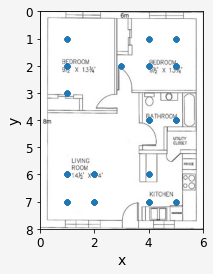

In [11]:
position = df.loc[:,['x', 'y']]
plotTrain(position,'minespark.jpg', 6, 8)

In [12]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

In [14]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear")

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [27]:
from sklearn.model_selection import cross_val_predict, cross_val_score
# train_df.info()

features = train_df.iloc[:, 3:37].to_numpy()
# features
classes = train_df['x']

predict = cross_val_predict(forest_reg, features, classes, method='predict', cv=3)
                        
# predict

In [29]:
# target = train_df['position']
# plot(target, predict)

TypeError: plot() missing 3 required positional arguments: 'fig_name', 'width', and 'height'

In [ ]:
# score = cross_val_score(knn, df['theta'], df['position'],
#                          scoring='neg_root_mean_squared_error', cv=3)

In [ ]:
# score

In [ ]:
# test_df = txtToDataFrame('test11_16.txt')
# test_df = process(test_df, sorted_mac)

In [ ]:
# test_df

In [ ]:
# final_predit = knn.predict(test_df['theta'])